# Don't Eat that Mushroom! Classifying Mushrooms as Poisonous or Non-Poisonous

While on a walk in the woods, the process of identifying poisonous mushrooms does not benefit from an easy to remember rule, such as the "leaves of three, let it be" rule for poison ivy. So, which mushroom features, from the color of its spots to the size of its gills to the habitat where it grows, can identify mushrooms as poisonous? The mushroom dataset from _The Audubon Society Field Guide to North American Mushrooms_ describes mushrooms according to their physical characteristics and whether or not the mushroom is poisonous. Apply different classification algorithms to the mushroom dataset to identify an algorithm that best fits the data and return the top features that classify a mushroom as poisonous vs non-poisonous.

# Import Packages and Modules

In [1]:
import os

from cycler import cycler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_predict, 
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    recall_score,
    roc_auc_score, 
    precision_score,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier

# Settings

In [2]:
# Notebook settings
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

# Plot settings
alpha_mpl = 0.75
color_cycle = ['dodgerblue', '#d5019a', 'midnightblue', 'gray']
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# File settings
data_raw = os.path.abspath('./data/raw/')

# Import Data

Download the Mushrooms dataset `agaricus-lepiota.data` from the UCI Machine Learning Repository at [https://archive.ics.uci.edu/ml/datasets/mushroom](https://archive.ics.uci.edu/ml/datasets/mushroom). Then place the CSV file in the `/data/raw/` directory. Columns names are specified at [https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.names).

In [3]:
csv = os.path.join(data_raw, 'agaricus-lepiota.data')
column_names = [
    'class',
    'cap-shape', 
    'cap-surface', 
    'cap-color', 
    'bruises?',
    'odor',
    'gill-attachment',
    'gill-spacing',
    'gill-size',
    'gill-color',
    'stalk-shape',
    'stalk-root',
    'stalk-surface-above-ring',
    'stalk-surface-below-ring',
    'stalk-color-above-ring',
    'stalk-color-below-ring',
    'veil-type',
    'veil-color',
    'ring-number',
    'ring-type',
    'spore-print-color',
    'population',
    'habitat',
]
df_m = pd.read_csv(csv, sep=',', header=0, names=column_names)

df_m.columns = df_m.columns.str.strip().str.lower().str.replace(' ', '_')
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 23 columns):
class                       8123 non-null object
cap-shape                   8123 non-null object
cap-surface                 8123 non-null object
cap-color                   8123 non-null object
bruises?                    8123 non-null object
odor                        8123 non-null object
gill-attachment             8123 non-null object
gill-spacing                8123 non-null object
gill-size                   8123 non-null object
gill-color                  8123 non-null object
stalk-shape                 8123 non-null object
stalk-root                  8123 non-null object
stalk-surface-above-ring    8123 non-null object
stalk-surface-below-ring    8123 non-null object
stalk-color-above-ring      8123 non-null object
stalk-color-below-ring      8123 non-null object
veil-type                   8123 non-null object
veil-color                  8123 non-null object
ring-number

Convert columns to categories to reduce memory footprint.

In [4]:
df_m = df_m.astype('category')
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8123 entries, 0 to 8122
Data columns (total 23 columns):
class                       8123 non-null category
cap-shape                   8123 non-null category
cap-surface                 8123 non-null category
cap-color                   8123 non-null category
bruises?                    8123 non-null category
odor                        8123 non-null category
gill-attachment             8123 non-null category
gill-spacing                8123 non-null category
gill-size                   8123 non-null category
gill-color                  8123 non-null category
stalk-shape                 8123 non-null category
stalk-root                  8123 non-null category
stalk-surface-above-ring    8123 non-null category
stalk-surface-below-ring    8123 non-null category
stalk-color-above-ring      8123 non-null category
stalk-color-below-ring      8123 non-null category
veil-type                   8123 non-null category
veil-color                

# Review Data

In [5]:
df_m.head(3)
df_m.sample(3)
df_m.tail(3)

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u


,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
6446,p,x,s,n,f,y,f,c,n,b,...,s,w,p,p,w,o,e,w,v,d
2122,e,x,f,n,t,n,f,c,b,u,...,s,w,p,p,w,o,p,k,v,d
206,e,b,s,w,t,a,f,c,b,k,...,s,w,w,p,w,o,p,k,s,m


,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l
8122,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,o,c,l


A `?` is used in this dataset to indicate missing data. Replace question marks with NaNs so the missing values are easier to handle.

In [6]:
df_m.replace('?', np.nan, inplace=True)
df_m.isnull().sum()

class                          0
cap-shape                      0
cap-surface                    0
cap-color                      0
bruises?                       0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
dtype: int64

In [7]:
print(
    'Percentage of NaNs in stalk-root column: {:.2%}'
    .format(df_m['stalk-root'].isnull().sum() / df_m.shape[0])
)

Percentage of NaNs in stalk-root column: 30.53%


There are too many rows with `NaNs` in the `stalk-root` column to drop them and the `stalk-root` column may or may not be predictive of the poisonous class. Dropping those rows would remove 30% of a relatively small dataset, so for the time being create a new category called `u` to stand for `unknown` and replace the `NaNs` with `u`. If the final model identifies `stalk-root` as predictive, reevaluate this issue.

Will the `u` value conflict with any existing values in the `stalk-root` column?

In [8]:
df_m['stalk-root'].value_counts()

b    3776
e    1119
c     556
r     192
?       0
Name: stalk-root, dtype: int64

Remove the `?` value from category values and replace NaNs with `u`.

In [9]:
df_m['stalk-root'] = (
    df_m['stalk-root']
    .cat.add_categories('u')
    .cat.remove_categories('?')
)
df_m['stalk-root'].fillna('u', inplace=True)
df_m['stalk-root'].value_counts()

b    3776
u    2480
e    1119
c     556
r     192
Name: stalk-root, dtype: int64

In [10]:
df_m.isnull().sum()

class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises?                    0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64

## Data Attributes

The data in the dataset is qualitative only. The columns and values in the dataset are as follows:

* `class`: edible=e, poisonous=p
* `cap-shape`: bell=b, conical=c, convex=x, flat=f, knobbed=k, sunken=s
* `cap-surface`: fibrous=f, grooves=g, scaly=y, smooth=s
* `cap-color`: brown=n, buff=b, cinnamon=c, gray=g, green=r, pink=p, purple=u, red=e, white=w, yellow=y
* `bruises`: bruises=t, no=f
* `odor`: almond=a, anise=l, creosote=c, fishy=y, foul=f, musty=m, none=n, pungent=p, spicy=s
* `gill-attachment`: attached=a, descending=d, free=f, notched=n
* `gill-spacing`: close=c, crowded=w, distant=d
* `gill-size`: broad=b, narrow=n
* `gill-color`: black=k, brown=n, buff=b, chocolate=h, gray=g, green=r, orange=o, pink=p, purple=u, red=e, white=w, yellow=y
* `stalk-shape`: enlarging=e, tapering=t
* `stalk-root`: bulbous=b, club=c, cup=u, equal=e, rhizomorphs=z, rooted=r, missing=?
* `stalk-surface-above-ring`: fibrous=f, scaly=y, silky=k, smooth=s
* `stalk-surface-below-ring`: fibrous=f, scaly=y, silky=k, smooth=s
* `stalk-color-above-ring`: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
* `stalk-color-below-ring`: brown=n, buff=b, cinnamon=c, gray=g, orange=o, pink=p, red=e, white=w, yellow=y
* `veil-type`: partial=p, universal=u
* `veil-color`: brown=n, orange=o, white=w, yellow=y
* `ring-number`: none=n, one=o, two=t
* `ring-type`: cobwebby=c, evanescent=e, flaring=f, large=l, none=n, pendant=p, sheathing=s, zone=z
* `spore-print-color`: black=k, brown=n, buff=b, chocolate=h, green=r, orange=o, purple=u, white=w, yellow=y
* `population`: abundant=a, clustered=c, numerous=n, scattered=s, several=v, solitary=y
* `habitat`: grasses=g, leaves=l, meadows=m, paths=p, urban=u, waste=w, woods=d

## Data Visualization

Plot the value counts of values in each column.

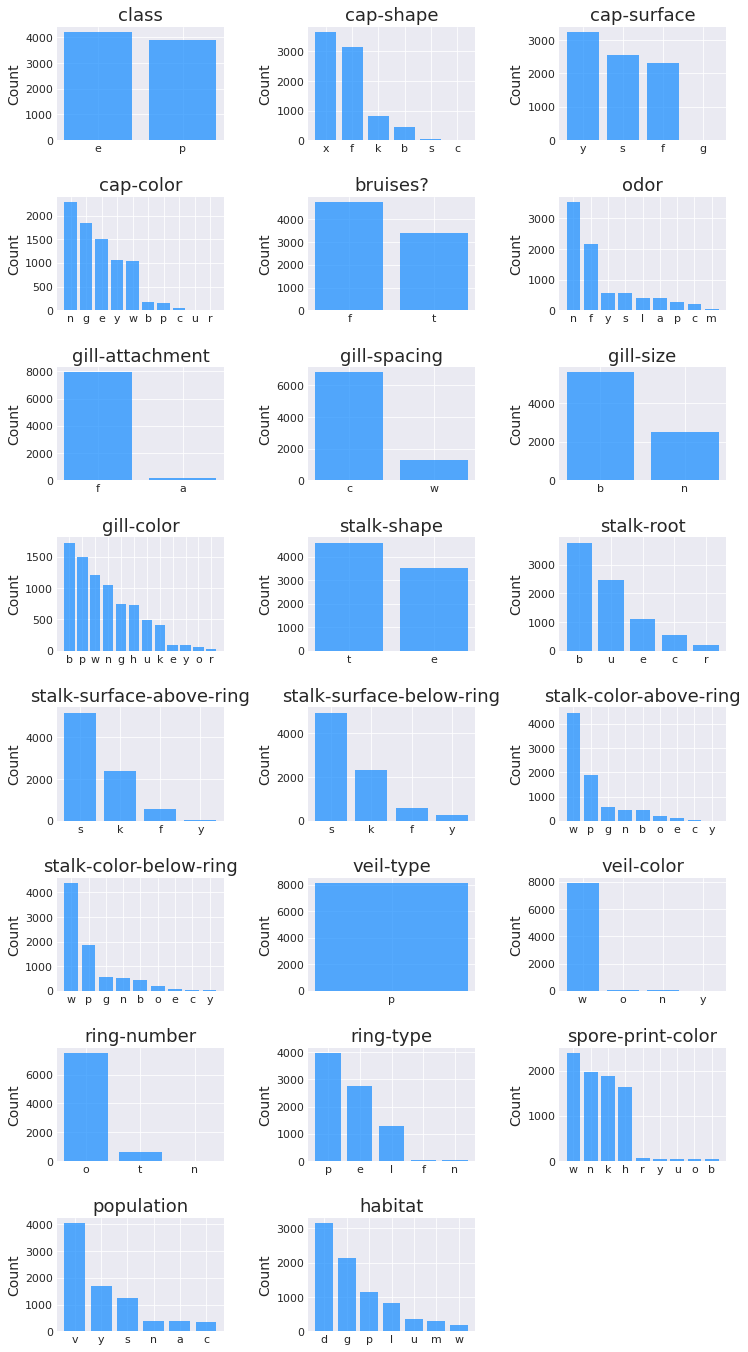

In [11]:
fig, axes = plt.subplots(figsize=(12, 24))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for idx, col in enumerate(df_m.columns):

    height = df_m[col].value_counts().values
    labels = df_m[col].value_counts().index.tolist()
    y_pos = np.arange(len(labels))

    ax = plt.subplot(8, 3, idx+1)
    ax.bar(y_pos, height, alpha=alpha_mpl)
    ax.set_xticks(y_pos)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Count')
    ax.set_title(col)

plt.show();

The value counts range from one value in the `veil-type` column to 12 values in the `gill-color` column.

The class labels in the `class` column appear to be relatively balanced in the bar chart. For a more specific breakdown of the class balance, what is the percentage per class?

In [12]:
print(
    'Edible: {:.2%}'
    .format(df_m[df_m['class'] == 'e'].shape[0] / df_m.shape[0])
)
print(
    'Poisonous: {:.2%}'
    .format(df_m[df_m['class'] == 'p'].shape[0] / df_m.shape[0])
)

Edible: 51.80%
Poisonous: 48.20%


The classes are relatively balanced. No further balancing is necessary for this analysis.

# Encode Data

Most of the algorithms used in this analysis will need the categorical data transformed into numerical dummy variables. 

In [13]:
s_class = pd.Series(LabelEncoder().fit_transform(df_m['class']))
df_dummy = pd.get_dummies(
    df_m.drop('class', axis='columns'), 
    columns=df_m.columns[1:],
)

df_m_dum = pd.concat([s_class, df_dummy], axis='columns')
df_m_dum.rename({0: 'class'}, axis='columns', inplace=True)

df_m_dum.shape
df_m_dum.head(3)
df_m_dum.sample(3)
df_m_dum.tail(3)

(8123, 118)

,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
0,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,1,0


,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
3858,1,0,0,0,0,0,1,1,0,0,...,0,1,0,1,0,0,0,0,0,0
3697,0,0,0,1,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
7924,1,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,1,0,0


,class,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,...,population_s,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w
8120,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
8121,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
8122,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,1,0,0,0,0


A `1` in the class column indicates the poisonous and a `0` indicates non-poisonous.

# Model Selection

To select the "best" model for this dataset, use cross validation to fit various classification algorithms and compare their metrics. The "best" model in this context will balance Accuracy with minimizing False Negatives. In this context a False Negative is classifying a poisonous mushroom as non-poisonous, which is a potentially fatal situation for humans. False Negatives and False Positives are in tension with each other, and it's safer for humans in this context if some False Positives are returned by the model, i.e. some non-poisonous mushrooms are classified as poisonous. For each model that is considered, use the Accuracy metric for a general understanding of the performance algorithms and a confusion matrix to monitor the rate of False Positive vs False Negative classifications. Also include the standard deviation for Accuracy, Precision, Recall and ROC AUC.

The following classification algorithms will be considered below:
* Decision Trees
* Random Forests
* K-Nearest Neighbors
* Logistic Regression

In [14]:
X = df_m_dum.drop('class', axis='columns')
y = df_m_dum['class']
print('Number of dummy observations and features: {}'.format(X.shape))

# Convert categorical string variables to numerical categories for 
# Decision Trees.
X_num = df_m.drop('class', axis='columns').apply(lambda col: col.cat.codes)
y_num = df_m['class'].cat.codes
print('Number of numerical observations and features: {}'.format(X_num.shape))

models_metrics = {}

def display_metrics(classifier, classifier_name, X, y, metrics):
    '''Display model metrics.
    
    Parameters
    ----------
    classifier : scikit-learn algorithm object
        Includes any specified parameters.
    X : pd.DataFrame of predictors
        Features.
    y : pd.Series of labels
        Target classes.
    
    Returns
    -------
    metrics : dictionary
        Algorithm metrics.
    '''
    accuracy = cross_val_score(
        classifier, 
        X, 
        y, 
        scoring='accuracy', 
        cv=5, 
        error_score=np.nan,
    )
    acc = '{0:.4f} (+/- {1:.4f})'.format(accuracy.mean(), (accuracy.std() * 2))
    print('Average Accuracy with SD: {})'.format(acc))
    
    precision = cross_val_score(
        classifier, 
        X, 
        y, 
        scoring='precision', 
        cv=5, 
        error_score=np.nan,
    )
    prec = '{0:.4f} (+/- {1:.4f})'.format(
        precision.mean(), 
        (precision.std() * 2),
    )
    print('Average Precision with SD: {})'.format(prec))
    
    recall = cross_val_score(
        classifier, 
        X, 
        y, 
        scoring='recall', 
        cv=5, 
        error_score=np.nan,
    )
    rec = '{0:.4f} (+/- {1:.4f})'.format(recall.mean(), (recall.std() * 2))
    print('Average Recall with SD: {})'.format(rec))
    
    roc_auc = cross_val_score(
        classifier, 
        X, 
        y, 
        scoring='roc_auc', 
        cv=5, 
        error_score=np.nan,
    )
    auc = '{0:.4f} (+/- {1:.4f})'.format(roc_auc.mean(), (roc_auc.std() * 2))
    print('Average ROC AUC with SD: {})'.format(auc))
    
    y_pred = cross_val_predict(classifier, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    print('True Positives: {}'.format(conf_matrix[1][1]))
    print('False Positives: {}'.format(conf_matrix[0][1]))
    print('False Negatives: {}'.format(conf_matrix[1][0]))
    print('True Negatives: {}'.format(conf_matrix[0][0]))
    
    metrics[classifier_name] = [
        acc, prec, rec, auc, conf_matrix[1][1], conf_matrix[0][1], 
        conf_matrix[1][0], conf_matrix[0][0]
    ]
    return metrics

Number of dummy observations and features: (8123, 117)
Number of numerical observations and features: (8123, 22)


## Decision Trees

Decision Trees predict the class of an observation by utilizing multiple layers of if-then-else decision rules. The more layers of rules, the more accurate the final predictions will be.

The scikit-learn implementation of Decision Trees allows categorical data, but it does not allow string categorical data. Use the data set that was converted to numbers.

In [15]:
models_metrics = display_metrics(
    DecisionTreeClassifier(), 
    'decision_tree_num', 
    X_num, 
    y_num, 
    models_metrics,
)

Average Accuracy with SD: 0.9169 (+/- 0.2064))
Average Precision with SD: 0.9168 (+/- 0.3328))
Average Recall with SD: 0.9349 (+/- 0.2605))
Average ROC AUC with SD: 0.9008 (+/- 0.2659))
True Positives: 3656
False Positives: 408
False Negatives: 259
True Negatives: 3800


## Random Forests

Random Forests is an ensemble algorithm that builds multiple Decision Trees models, aggregates classifications across those models and outputs the most frequent class for an observation.

In [16]:
models_metrics = display_metrics(
    RandomForestClassifier(n_estimators=100), 
    'random_forest', 
    X, 
    y, 
    models_metrics,
)

Average Accuracy with SD: 0.9216 (+/- 0.1984))
Average Precision with SD: 0.9429 (+/- 0.2285))
Average Recall with SD: 0.9341 (+/- 0.2598))
Average ROC AUC with SD: 0.9996 (+/- 0.0016))
True Positives: 3660
False Positives: 352
False Negatives: 255
True Negatives: 3856


## K-Nearest Neighbors

K-Nearest Neighbors is a non-parametric classification algorithm which groups an observation with them most common class among the observation's `k` nearest neighbors, i.e. majority rules.

A general number for `k` in K-NN is to take the square root of the number of observations in the dataset. It's also helpful to set k to an odd number when the number of classes is even to avoid ties when observations are scored by the algorithm.

In [17]:
n = X.shape[0]
k = round(n ** (1/2))
if k % 2 == 0:
    k += 1

models_metrics = display_metrics(
    KNeighborsClassifier(), 
    'k_nn', 
    X, 
    y, 
    models_metrics,
)

Average Accuracy with SD: 0.8973 (+/- 0.2786))
Average Precision with SD: 0.9151 (+/- 0.3394))
Average Recall with SD: 0.9344 (+/- 0.2525))
Average ROC AUC with SD: 0.9461 (+/- 0.1321))
True Positives: 3658
False Positives: 577
False Negatives: 257
True Negatives: 3631


## Logistic Regression

Binary Logistic Regression is a classification algorithm that utilizes the sigmoid function to output a probability of belonging to a class and then maps that probability to either a positive class or a negative class. 

Use L1 Lasso regularization, which drives the coefficients of less important features to zero, to eliminate those  features from the model entirely. Regularization creates a more parsimonious model which is less prone to overfitting and more interpretable.

In [18]:
models_metrics = display_metrics(
    LogisticRegression(penalty='l1', solver='liblinear'), 
    'logistic_regression', 
    X, 
    y, 
    models_metrics,
)

Average Accuracy with SD: 0.9756 (+/- 0.0933))
Average Precision with SD: 0.9608 (+/- 0.1569))
Average Recall with SD: 0.9982 (+/- 0.0072))
Average ROC AUC with SD: 0.9999 (+/- 0.0002))
True Positives: 3908
False Positives: 191
False Negatives: 7
True Negatives: 4017


## Model Selection

Compare the metrics of the various models.

In [19]:
labels_metrics = [
    'Average Accuracy', 
    'Average Precision', 
    'Average Recall', 
    'Average ROC AUC', 
    'True Positives', 
    'False Positives', 
    'False Negatives', 
    'True Negatives',
]
rename_index = dict(zip(list(range(8)), labels_metrics))
(
    pd.DataFrame
    .from_dict(models_metrics, orient='columns')
    .rename(rename_index, axis='index')
)

,decision_tree_num,random_forest,k_nn,logistic_regression
Average Accuracy,0.9169 (+/- 0.2064),0.9216 (+/- 0.1984),0.8973 (+/- 0.2786),0.9756 (+/- 0.0933)
Average Precision,0.9168 (+/- 0.3328),0.9429 (+/- 0.2285),0.9151 (+/- 0.3394),0.9608 (+/- 0.1569)
Average Recall,0.9349 (+/- 0.2605),0.9341 (+/- 0.2598),0.9344 (+/- 0.2525),0.9982 (+/- 0.0072)
Average ROC AUC,0.9008 (+/- 0.2659),0.9996 (+/- 0.0016),0.9461 (+/- 0.1321),0.9999 (+/- 0.0002)
True Positives,3656,3660,3658,3908
False Positives,408,352,577,191
False Negatives,259,255,257,7
True Negatives,3800,3856,3631,4017


Identifying False Negatives, that is classifying a poisonous mushroom as non-poisonous, is the most important metric in selecting an algorithm in this analysis. Logistic Regression returned the fewest False Negatives, has the highest Average Recall and has the highest Average Accuracy. Use Logistic Regression going forward. 

# Optimize and Train Model

To find the best fitting model for this data where the False Negatives are minimized, perform a grid search using the `tol` and `C` parameters. The `tol` parameter indicates a threshold where convergence has been reached, which stops the training process to prevent overfitting. The `C` parameter dictates the strength of the regularization; the smaller the value the stronger regularization. Limit the solvers to `liblinear`, which converges quickly for this dataset. Use `L1` regularization to shrink less important features to zero, creating a more parsimonious model. 

In [20]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 
    'tol': [1.0, 0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(
    lr, 
    param_grid=param_grid, 
    verbose=0, 
    scoring='recall', 
    cv=5, 
    return_train_score=True,
)
grid_search.fit(X, y)

print('Best Recall Score: {}'.format(grid_search.best_score_))
print('Best Estimator: {}'.format(grid_search.best_estimator_))
print('Best Parameters: {}'.format(grid_search.best_params_))

GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l1',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'tol': [1.0, 0.1, 0.01, 0.001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='recall', verbose=0)

Best Recall Score: 0.9982120051085568
Best Estimator: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=False)
Best Parameters: {'C': 1, 'tol': 0.001}


# Model Results

The highest Recall score is the model with the following parameters: `C=1`, `tol=0.001`. Now that the model has been selected, train the model on the entire dataset, return a metrics for evaluation and identify the most important features in the model.

Adjust the weights of the classes slightly so that the model minimizes False Negatives, which in this context is classifying a poisonous mushroom as non-poisonous.

In [21]:
lr = LogisticRegression(
    penalty='l1', 
    tol=0.001, 
    C=1, 
    solver='liblinear', 
    class_weight={0: 0.045, 1: 0.955}, 
    random_state=12,
)

y_pred = lr.fit(X, y).predict(X)
conf_matrix = confusion_matrix(y, y_pred)

acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)
rec = recall_score(y, y_pred)
roc_auc = roc_auc_score(y, y_pred)
tp = conf_matrix[1][1]
fp = conf_matrix[0][1]
fn = conf_matrix[1][0]
tn = conf_matrix[0][0]

final_metrics = {
    'Accuracy': acc, 
    'Precision': prec, 
    'Recall': rec, 
    'ROC AUC': roc_auc, 
    'True Positives': tp, 
    'False Positives': fp, 
    'False Negatives': fn, 
    'True Negatives': tn,
}

pd.DataFrame.from_dict(final_metrics, orient='index', columns=['metric'])

,metric
Accuracy,0.997045
Precision,0.993907
Recall,1.000000
ROC AUC,0.997148
True Positives,3915.000000
False Positives,24.000000
False Negatives,0.000000
True Negatives,4184.000000


This model does return a small number of False Positives. But given the deadly nature of poisonous mushrooms, the Recall score needed to be emphasized over the Precision score.

# Most Important Features

A straight forward approach to identifying the most important features in the model is to use the coefficients produced by the model. In this model, a positive coefficient guides the classification toward the poisonous class and a negative coefficient guides the classification toward the non-poisonous class.

In [22]:
important_feat = dict(zip(X.columns.tolist(), lr.coef_[0]))

df_if = pd.DataFrame.from_dict(
    important_feat, 
    orient='index', 
    columns=['coefficient'],
)

mask_coef = df_if['coefficient'] != 0
contrib_coeff = df_if[mask_coef].shape[0]
print('Number of contributing coefficients in model: {}'.format(contrib_coeff))
print('Number of observations: {}'.format(X.shape[0]))

(
    df_if[df_if['coefficient'] > 0]
    .sort_values('coefficient', ascending=False)
    .head(5)
)
df_if[df_if['coefficient'] < 0].sort_values('coefficient').head(5)

Number of contributing coefficients in model: 30
Number of observations: 8123


,coefficient
spore-print-color_r,7.148750
odor_f,3.689995
gill-size_n,2.927555
stalk-surface-above-ring_k,2.148829
stalk-surface-below-ring_y,1.642041


,coefficient
odor_n,-5.176410
odor_l,-5.151472
odor_a,-5.148457
gill-size_b,-0.652875
population_y,-0.511285


The top three most important features for identifying a **poisonous** mushroom are:

1. Green spore print
2. Creosote odor
3. Pungent odor
4. Silky stalk surface above the ring
5. Foul odor

The top five most important features for identifying a **non-poisonous** mushroom are:

1. Anise odor
2. No odor
3. Almond odor
4. Brown spore print
5. Flaring ring type

Overall, it appears that the most important sense to use when distinguishing between a poisonous and non-poisonous mushroom is your nose. If it smells "bad", walk away.